In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
from wordcloud import WordCloud

import re
import csv
import string
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from collections import Counter

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import SpatialDropout1D, Embedding, SimpleRNN, LSTM, Bidirectional, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization


from sklearn.preprocessing import StandardScaler, LabelEncoder

import warnings
warnings.filterwarnings('ignore')


nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
"""
https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data
"""

df = pd.read_csv('IMDB Dataset.csv', on_bad_lines='skip')
# Segmenting a portion of the dataset for code testing (10% of data)
# df = df.sample(frac=0.1, random_state=42).reset_index(drop=True)
print("Sampled dataset shape:", df.shape)

Sampled dataset shape: (50000, 2)


Vocabulary Size: 101583
String Length - Min: 32, Max: 13704, Mean: 1309.43
Word Count - Min: 4, Max: 2470, Mean: 231.16
Average Word Length - Min: 1.24, Max: 12.29, Mean: 4.64


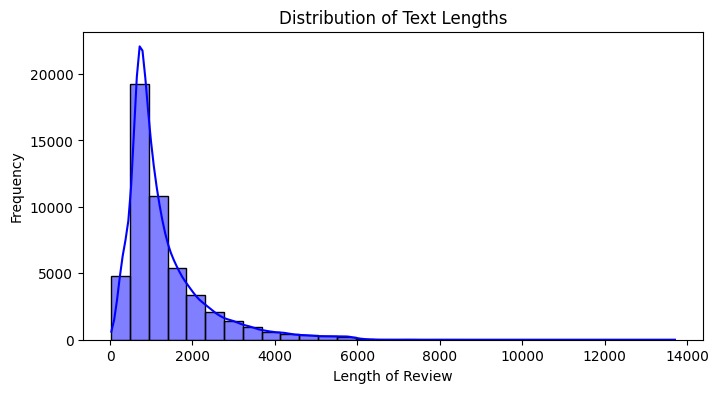

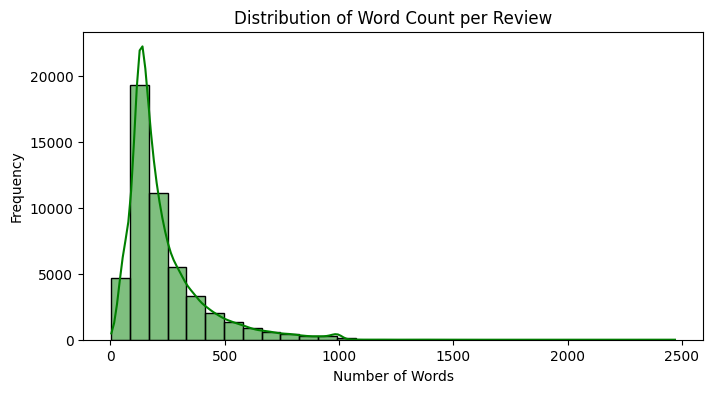

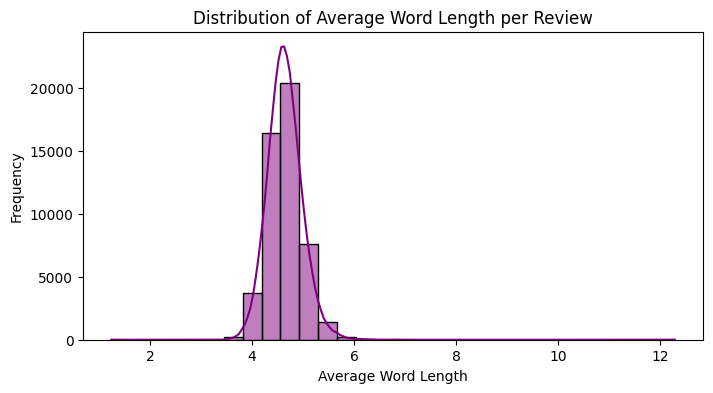

In [ ]:
# Vectorization and Vocabulary Size
vectorizer = CountVectorizer(stop_words='english')
X_counts = vectorizer.fit_transform(df['review'])
vocab_size = len(vectorizer.vocabulary_)

# Basic statistics: String length
df['text_length'] = df['review'].apply(len)

# Words per review
df['word_count'] = df['review'].apply(lambda x: len(x.split()))

# Average word length per review
avg_word_length = lambda text: np.mean([len(word) for word in text.split()]) if text.split() else 0
df['avg_word_length'] = df['review'].apply(avg_word_length)

# Display statistics
print(f"Vocabulary Size: {vocab_size}")
print(f"String Length - Min: {df['text_length'].min()}, Max: {df['text_length'].max()}, Mean: {df['text_length'].mean():.2f}")
print(f"Word Count - Min: {df['word_count'].min()}, Max: {df['word_count'].max()}, Mean: {df['word_count'].mean():.2f}")
print(f"Average Word Length - Min: {df['avg_word_length'].min():.2f}, Max: {df['avg_word_length'].max():.2f}, Mean: {df['avg_word_length'].mean():.2f}")

# Plot: Distribution of text lengths
plt.figure(figsize=(8, 4))
sns.histplot(df['text_length'], bins=30, kde=True, color='blue')
plt.title("Distribution of Text Lengths")
plt.xlabel("Length of Review")
plt.ylabel("Frequency")
plt.show()

# Plot: Word count per review
plt.figure(figsize=(8, 4))
sns.histplot(df['word_count'], bins=30, kde=True, color='green')
plt.title("Distribution of Word Count per Review")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# Plot: Average word length per review
plt.figure(figsize=(8, 4))
sns.histplot(df['avg_word_length'], bins=30, kde=True, color='purple')
plt.title("Distribution of Average Word Length per Review")
plt.xlabel("Average Word Length")
plt.ylabel("Frequency")
plt.show()

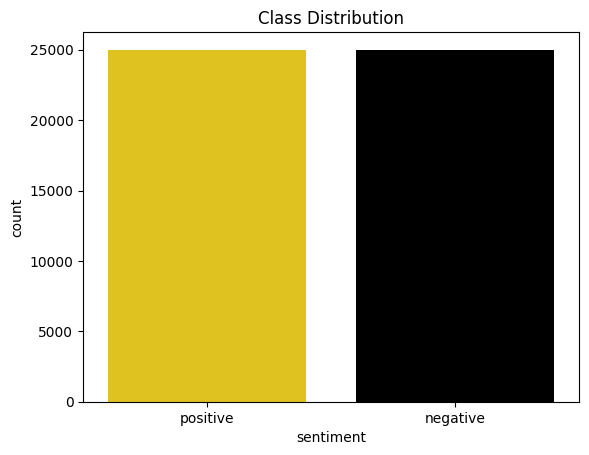

In [ ]:
# Plot: Class distribution
sns.countplot(x=df['sentiment'], palette=['#FFD700', '#000000'])
plt.title("Class Distribution")
plt.show()

In [ ]:
print(df.info())
print()
print(df.isnull().sum())
print()
print('Dataframe shape:', df.shape)
print()
print('Duplicates:', df.duplicated().sum())
df = df.drop_duplicates(keep='first')
print('Shape after dropping duplicates:', df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review       50000 non-null  object
 1   sentiment    50000 non-null  object
 2   text_length  50000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB
None

review         0
sentiment      0
text_length    0
dtype: int64

Dataframe shape: (50000, 3)

Duplicates: 418
Shape after dropping duplicates: (49582, 3)


Percentage of 0: 50.19%
Percentage of 1: 49.81%


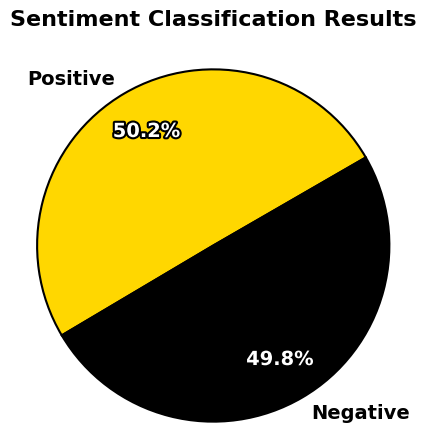

In [ ]:
values = df['sentiment'].value_counts()

total = values.sum()

percentage_0 = (values.get(0, 0) / total) * 100
percentage_1 = (values.get(1, 0) / total) * 100

print(f'Percentage of 0: {percentage_0:.2f}%')
print(f'Percentage of 1: {percentage_1:.2f}%')

#Define labels and colors
labels = ['Positive', 'Negative']

colors = ['#FFD700', '#000000']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_facecolor('#f5f5f5')

wedges, texts, autotexts = ax.pie(
    values, labels=labels,
    autopct='%0.1f%%',
    startangle=30,
    colors=colors,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
    explode=(0, 0),
    shadow=False,
    pctdistance=0.75,
    labeldistance=1.1
)

for text in texts:
    text.set(size=14, fontweight='bold', color='black')

shadow_effect = [path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]

for autotext in autotexts:
    autotext.set(size=14, fontweight='bold', color='white', path_effects=shadow_effect)

ax.axis('equal')

ax.set_title('Sentiment Classification Results', fontsize=16, fontweight='bold', pad=20)

ax.axis('equal')

plt.show()

In [ ]:
print(df['sentiment'].value_counts())

sentiment
positive    24884
negative    24698
Name: count, dtype: int64


In [ ]:
# For preprocessing in our statistical models, we fixed some lemmatizing issues
# from assignment 1, removed stemming, and proceeded with standard removal
# of stopwords, pos tagging, lowercasing, and removing numeric characters.

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def get_wordnet_pos(treebank_tag):
    """Convert POS tag to WordNet POS tag format"""
    if treebank_tag.startswith('V'):
        return 'v'  # Verb
    elif treebank_tag.startswith('N'):
        return 'n'  # Noun
    elif treebank_tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'a'  # Default to adjective

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tagged_tokens = pos_tag(tokens)

    processed_tokens = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in tagged_tokens
        if word.isalpha() and word not in stop_words  # Remove digits & stopwords
    ]

    return " ".join(processed_tokens)

# Example
print(preprocess_text("I waited 30 minutes, then watched a movie in 2024."))

wait minute watch movie


In [ ]:
def tokenize(text):
  return text.split()

In [ ]:
preprocess_text('Goes until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...')

'go jurong point crazy available bugis n great world la e buffet cine get amore wat'

In [ ]:
!pip install swifter

import swifter # allows parallelism on multicore CPU, doubles speed here

df['text_transformed'] = df['review'].swifter.apply(preprocess_text)
df['tokens'] = df['text_transformed'].swifter.apply(tokenize)

Pandas Apply:   0%|          | 0/49582 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/49582 [00:00<?, ?it/s]

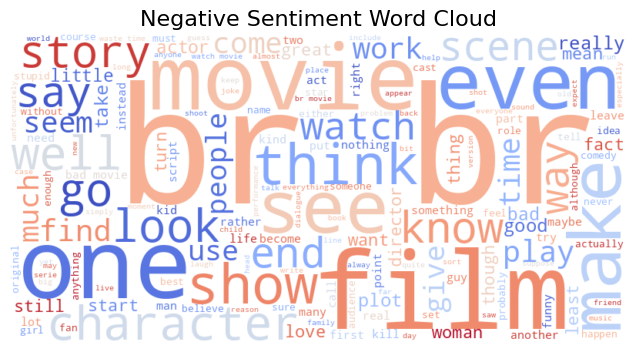

In [ ]:
wc = WordCloud(
    width=800,
    height=400,
    min_font_size=10,
    background_color='white',
    colormap='coolwarm'
)

neg_wc = wc.generate(' '.join(df[df['sentiment'] == 'negative']['text_transformed']))

plt.figure(figsize=(8, 4))
plt.imshow(neg_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Sentiment Word Cloud", fontsize=16)
plt.show()

From the word cloud, we see that many common 'movie review' words like 'movie,' 'film,' 'story,' etc, so we chose to remove the 50 most common words, as well as any word appearing only once, from the dataset.

In [ ]:
# Compute word frequency AFTER text transformation & tokenization
all_words = [word for tokens in df['tokens'] for word in tokens]

word_counts = Counter(all_words)
common_words = {word for word, count in word_counts.most_common(50)}  # Top 50 most frequent words
rare_words = {word for word, count in word_counts.items() if count == 1}  # Words appearing only once

# Remove common and rare words from tokenized text
df['filtered_tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in common_words and word not in rare_words])

# Convert back to text
df['filtered_review'] = df['filtered_tokens'].apply(lambda tokens: ' '.join(tokens))

# Check most common words after filtering
filtered_word_counts = Counter(" ".join(df['filtered_review']).split())
print("Top 30 words after filtering:", filtered_word_counts.most_common(30))

Top 30 words after filtering: [('try', 12272), ('little', 12220), ('year', 12135), ('ever', 11618), ('man', 11051), ('still', 10777), ('part', 9980), ('something', 9831), ('use', 9610), ('lot', 9564), ('back', 9435), ('funny', 9291), ('director', 9177), ('old', 9101), ('real', 8920), ('guy', 8908), ('performance', 8790), ('woman', 8625), ('though', 8547), ('another', 8449), ('actually', 8384), ('acting', 8369), ('act', 8332), ('nothing', 8219), ('big', 8145), ('new', 8024), ('young', 8015), ('role', 8015), ('start', 7934), ('leave', 7902)]


In [ ]:
df

,review,sentiment,text_length,text_transformed,tokens,filtered_tokens,filtered_review
0,One of the other reviewers has mentioned that ...,positive,1761,one reviewer mention watch oz episode hook rig...,"[one, reviewer, mention, watch, oz, episode, h...","[reviewer, mention, oz, episode, hook, right, ...",reviewer mention oz episode hook right exactly...
1,A wonderful little production. <br /><br />The...,positive,998,wonderful little production br br filming tech...,"[wonderful, little, production, br, br, filmin...","[wonderful, little, production, filming, techn...",wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,926,think wonderful way spend time hot summer week...,"[think, wonderful, way, spend, time, hot, summ...","[wonderful, spend, hot, summer, weekend, sit, ...",wonderful spend hot summer weekend sit air con...
3,Basically there's a family where a little boy ...,negative,748,basically family little boy jake think zombie ...,"[basically, family, little, boy, jake, think, ...","[basically, family, little, boy, jake, zombie,...",basically family little boy jake zombie closet...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,petter mattei love time money visually stunnin...,"[petter, mattei, love, time, money, visually, ...","[mattei, money, visually, stunning, mattei, of...",mattei money visually stunning mattei offer us...
...,...,...,...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,1008,think movie right good job creative original f...,"[think, movie, right, good, job, creative, ori...","[right, job, creative, original, expect, whole...",right job creative original expect whole lotta...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,642,bad plot bad dialogue bad acting idiotic direc...,"[bad, plot, bad, dialogue, bad, acting, idioti...","[dialogue, acting, idiotic, directing, annoy, ...",dialogue acting idiotic directing annoy porn g...
49997,I am a Catholic taught in parochial elementary...,negative,1280,catholic taught parochial elementary school nu...,"[catholic, taught, parochial, elementary, scho...","[catholic, taught, parochial, elementary, scho...",catholic taught parochial elementary school nu...
49998,I'm going to have to disagree with the previou...,negative,1234,go disagree previous comment side maltin one s...,"[go, disagree, previous, comment, side, maltin...","[disagree, previous, comment, side, maltin, se...",disagree previous comment side maltin second r...


In [ ]:
neg_corpus = []

for sentence in df[df['sentiment'] == 'negative']['filtered_review'].tolist():
    for word in sentence.split():
        neg_corpus.append(word)

neg_wc = Counter(neg_corpus)
neg_wc = pd.DataFrame(neg_wc.most_common(30), columns=['Word', 'Frequency'])
neg_wc

,Word,Frequency
0,try,7436
1,ever,6357
2,little,5841
3,nothing,5759
4,something,5639
5,guy,5546
6,acting,5274
7,actually,5014
8,use,4943
9,director,4929


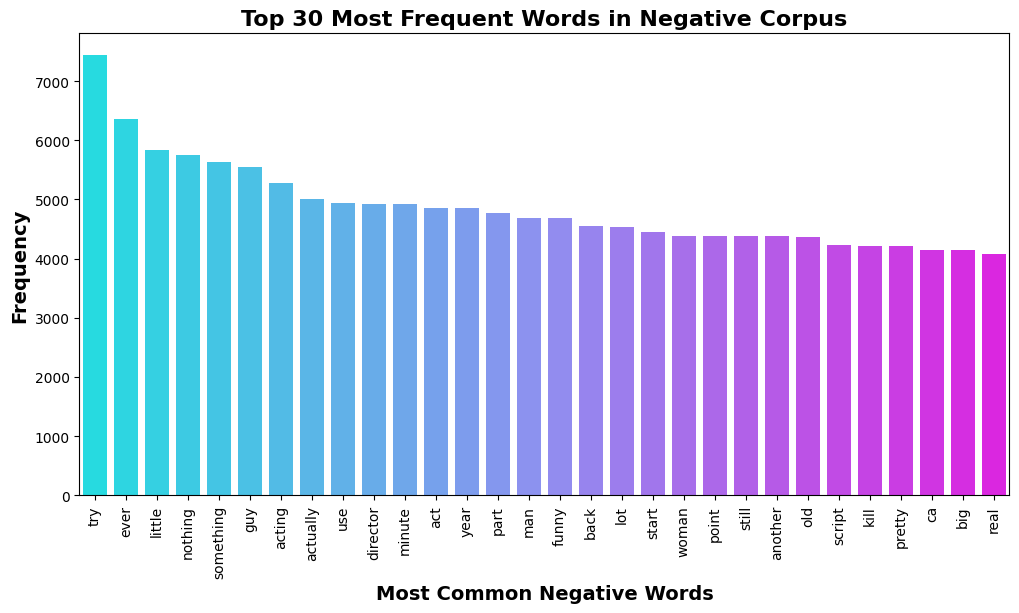

In [ ]:
plt.figure(figsize=(12,6))

sns.barplot(data=neg_wc, x='Word', y='Frequency', palette='cool')

plt.xticks(rotation=90)
plt.xlabel("Most Common Negative Words", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=14, fontweight='bold')
plt.title("Top 30 Most Frequent Words in Negative Corpus", fontsize=16, fontweight='bold')

plt.show()

In [ ]:
pos_corpus = []

for sentence in df[df['sentiment'] == 'positive']['filtered_review'].tolist():
    for word in sentence.split():
        pos_corpus.append(word)

pos_wc = Counter(pos_corpus)
pos_wc = pd.DataFrame(pos_wc.most_common(30), columns=['Word', 'Frequency'])
pos_wc

,Word,Frequency
0,year,7284
1,still,6395
2,little,6379
3,man,6356
4,performance,5854
5,ever,5261
6,part,5200
7,young,5075
8,lot,5021
9,role,4915


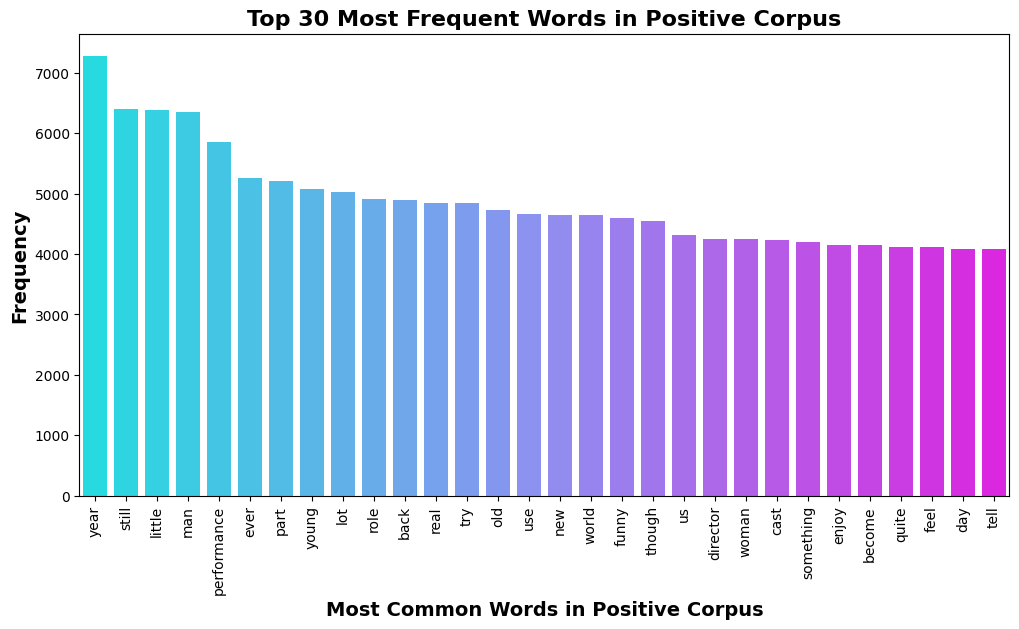

In [ ]:
plt.figure(figsize=(12,6))

sns.barplot(data=pos_wc, x='Word', y='Frequency', palette='cool')

plt.xticks(rotation=90)
plt.xlabel("Most Common Words in Positive Corpus", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=14, fontweight='bold')
plt.title("Top 30 Most Frequent Words in Positive Corpus", fontsize=16, fontweight='bold')

plt.show()

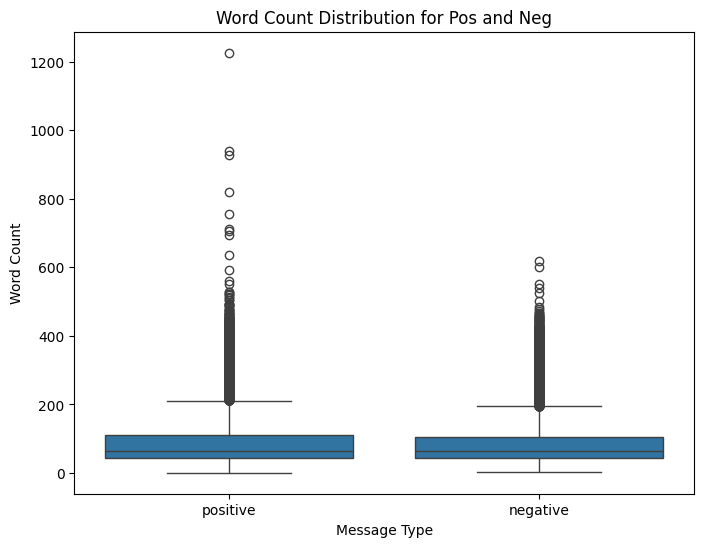

In [ ]:
df['word_count'] = df['filtered_review'].apply(lambda text: len(text.split()))
plt.figure(figsize=(8, 6))
sns.boxplot(x='sentiment', y='word_count', data=df)
plt.title('Word Count Distribution for Pos and Neg')
plt.xlabel('Message Type')
plt.ylabel('Word Count')
plt.show()

In [ ]:
def filter_pos(tokens, target_pos):
    """
    Filters the given tokens based on the specified part-of-speech (POS) tag.
    Returns a list of words that match the specified POS.
    """
    tagged = pos_tag(tokens)
    return [word for word, pos in tagged if pos.startswith(target_pos)]

In [ ]:
# Create different feature sets
df['nouns'] = df['tokens'].apply(lambda x: filter_pos(x, 'NN'))
df['verbs'] = df['tokens'].apply(lambda x: filter_pos(x, 'VB'))

In [ ]:
df.head()

,review,sentiment,text_length,text_transformed,tokens,filtered_tokens,filtered_review,word_count,nouns,verbs
0,One of the other reviewers has mentioned that ...,positive,1761,one reviewer mention watch oz episode hook rig...,"[one, reviewer, mention, watch, oz, episode, h...","[reviewer, mention, oz, episode, hook, right, ...",reviewer mention oz episode hook right exactly...,137,"[mention, watch, oz, episode, hook, br, thing,...","[happen, oz, set, go, hearted, emerald, privac..."
1,A wonderful little production. <br /><br />The...,positive,998,wonderful little production br br filming tech...,"[wonderful, little, production, br, br, filmin...","[wonderful, little, production, filming, techn...",wonderful little production filming technique ...,64,"[production, br, fashion, comforting, sense, r...","[filming, give, discomforting, michael, get, s..."
2,I thought this was a wonderful way to spend ti...,positive,926,think wonderful way spend time hot summer week...,"[think, wonderful, way, spend, time, hot, summ...","[wonderful, spend, hot, summer, weekend, sit, ...",wonderful spend hot summer weekend sit air con...,64,"[way, time, summer, weekend, sit, air, conditi...","[think, suspect, disappoint, realize, think, c..."
3,Basically there's a family where a little boy ...,negative,748,basically family little boy jake think zombie ...,"[basically, family, little, boy, jake, think, ...","[basically, family, little, boy, jake, zombie,...",basically family little boy jake zombie closet...,46,"[family, jake, zombie, closet, parent, fight, ...","[think, jake, become, go, decide, expect, see,..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,petter mattei love time money visually stunnin...,"[petter, mattei, love, time, money, visually, ...","[mattei, money, visually, stunning, mattei, of...",mattei money visually stunning mattei offer us...,82,"[petter, time, money, film, watch, mattei, por...","[offer, seem, tell, connect, know, sophisticat..."


In [ ]:
def train_and_evaluate(X_train, X_test, y_train, y_test, model):
    """
    Trains the given model on the training data and evaluates it on the test data.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pos', 'Neg'], yticklabels=['Pos', 'Neg'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    if hasattr(model, "predict_proba"):
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    else:
        roc_auc = None
    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "roc_auc": roc_auc
    }

def check_overfitting(model, X_train, X_test, y_train, y_test):
    """
    Checks for overfitting by comparing training and test accuracy,
    as well as AUC scores.
    """
    # Evaluate on training data
    y_train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)

    # Evaluate on test data
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)

    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    # Check for overfitting
    if train_acc > test_acc + 0.1:
        print("⚠️ Warning: Possible overfitting detected!")

    # If the model supports probability estimates
    if hasattr(model, "predict_proba"):
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]

        train_auc = roc_auc_score(y_train, y_train_proba)
        test_auc = roc_auc_score(y_test, y_test_proba)

        print(f"Training AUC: {train_auc:.4f}")
        print(f"Test AUC: {test_auc:.4f}")

        if train_auc > test_auc + 0.1:
            print("⚠️ Warning: Possible overfitting detected!")

def vectorize_and_train(feature_column, results):
    """
    Vectorizes the specified feature column and trains Naive Bayes and Logistic Regression models.
    Stores the results in the provided dictionary.
    """
    vectorizer = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, max_features=5000)
    X = vectorizer.fit_transform(df[feature_column])
    y = df['sentiment']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    results[feature_column] = {}  # Ensure dictionary is initialized

    print()
    print(f'--- Training Naive Bayes for {feature_column} ---')
    nb_model = MultinomialNB()
    results[feature_column]['Naive Bayes'] = train_and_evaluate(X_train, X_test, y_train, y_test, nb_model)
    print(results[feature_column]['Naive Bayes'])

    check_overfitting(nb_model, X_train, X_test, y_train, y_test)

    print()
    print(f'--- Training Logistic Regression for {feature_column} ---')
    lr_model = LogisticRegression(max_iter=1000, C=0.1)
    results[feature_column]['Logistic Regression'] = train_and_evaluate(X_train, X_test, y_train, y_test, lr_model)
    print(results[feature_column]['Logistic Regression'])

    check_overfitting(lr_model, X_train, X_test, y_train, y_test)


--- Training Naive Bayes for filtered_tokens ---
Accuracy: 0.8379550267217909
Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.84      0.84      4939
    positive       0.84      0.83      0.84      4978

    accuracy                           0.84      9917
   macro avg       0.84      0.84      0.84      9917
weighted avg       0.84      0.84      0.84      9917

Confusion Matrix:
 [[4163  776]
 [ 831 4147]]
ROC-AUC Score: 0.9073294433145036


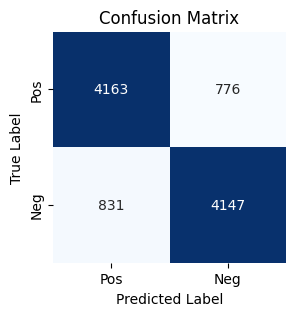

{'accuracy': 0.8379550267217909, 'roc_auc': np.float64(0.9073294433145036)}
Training Accuracy: 0.8497
Test Accuracy: 0.8380
Training AUC: 0.9181
Test AUC: 0.9073

--- Training Logistic Regression for filtered_tokens ---
Accuracy: 0.8676010890390239
Classification Report:
               precision    recall  f1-score   support

    negative       0.87      0.86      0.87      4939
    positive       0.86      0.88      0.87      4978

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917

Confusion Matrix:
 [[4245  694]
 [ 619 4359]]
ROC-AUC Score: 0.936823094708436


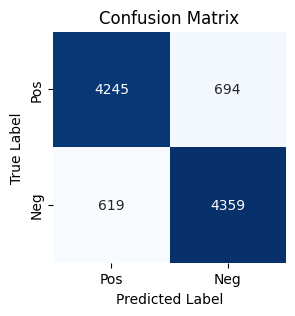

{'accuracy': 0.8676010890390239, 'roc_auc': np.float64(0.936823094708436)}
Training Accuracy: 0.9142
Test Accuracy: 0.8676
Training AUC: 0.9724
Test AUC: 0.9368


In [ ]:
results = {}
vectorize_and_train('filtered_tokens', results)

We tested the statistical models again, this time, using only data with word counts within the standard distribution. We saw minimal improvement, though both the Naive Bayes and Logistic models performed with ~1% higher accuracy.

In [ ]:
# Add a new column with word counts
df['word_count'] = df['text_transformed'].apply(lambda x: len(x.split()))

# Remove rows with more than 225 words
df = df[df['word_count'] <= 225]


--- Training Naive Bayes for filtered_tokens ---
Accuracy: 0.8516136312344843
Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.85      0.85      4407
    positive       0.85      0.85      0.85      4455

    accuracy                           0.85      8862
   macro avg       0.85      0.85      0.85      8862
weighted avg       0.85      0.85      0.85      8862

Confusion Matrix:
 [[3753  654]
 [ 661 3794]]
ROC-AUC Score: 0.9227890176759399


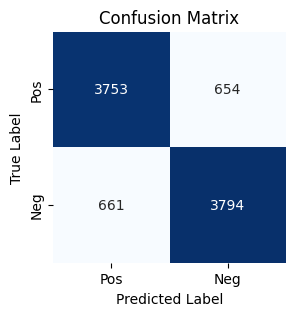

{'accuracy': 0.8516136312344843, 'roc_auc': np.float64(0.9227890176759399)}
Training Accuracy: 0.8615
Test Accuracy: 0.8516
Training AUC: 0.9289
Test AUC: 0.9228

--- Training Logistic Regression for filtered_tokens ---
Accuracy: 0.8744075829383886
Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.87      0.87      4407
    positive       0.87      0.88      0.88      4455

    accuracy                           0.87      8862
   macro avg       0.87      0.87      0.87      8862
weighted avg       0.87      0.87      0.87      8862

Confusion Matrix:
 [[3815  592]
 [ 521 3934]]
ROC-AUC Score: 0.9423113468344541


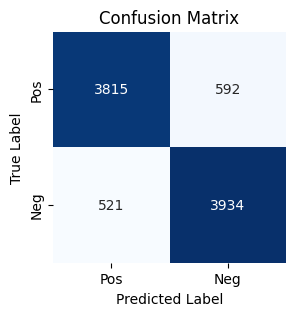

{'accuracy': 0.8744075829383886, 'roc_auc': np.float64(0.9423113468344541)}
Training Accuracy: 0.9135
Test Accuracy: 0.8744
Training AUC: 0.9719
Test AUC: 0.9423


In [ ]:
results = {}
vectorize_and_train('filtered_tokens', results)

####Model Vis function def

In [ ]:
def plot_model(model, history, X_test, y_test):
  # Plot the training and validation loss
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Plot the training and validation accuracy
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

  # Predict on the validation/test data
  y_pred = model.predict(X_test)
  y_pred_classes = (y_pred > 0.5).astype("int32")

  # Compute confusion matrix
  cm = confusion_matrix(y_test, y_pred_classes)

  # Visualize confusion matrix
  plt.figure(figsize=(6, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

  # Get predicted probabilities for the test set
  y_pred_prob = model.predict(X_test)

  # Compute ROC curve and AUC
  fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
  roc_auc = auc(fpr, tpr)

  # Plot ROC curve
  plt.figure(figsize=(8, 8))
  plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc='lower right')
  plt.show()

#Part 2: RNN Configurations

In [ ]:
df = pd.read_csv('IMDB Dataset.csv')
X = df['review']
y = df['sentiment']
X.shape

(50000,)

In [ ]:
# We used simpler preprocessing to avoid losing contextual information

max_words = 25000
max_len = 250

tokenizer=tf.keras.preprocessing.text.Tokenizer(num_words=max_words,filters="!@#$%^&*()<>{}[]''/?_+-=", lower=True)
tokenizer.fit_on_texts(X)

X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=max_len)

In [ ]:
encoder=LabelEncoder()
y=encoder.fit_transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)


##Part 2a: Design 1 vs Design 2 (simple)

###LSTM

In [ ]:
nn_results = {}

In [ ]:
"""
Embed words in 64 dimensions, tanh default LSTM act., rmsprop optimizer to
adapt learning rate per parameter
"""

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model.add(tf.keras.layers.LSTM(units=64,activation="tanh"))
model.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])
model.build(input_shape=(None, max_len))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 250, 64)             │       1,600,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,633,089 (6.23 MB)

 Trainable params: 1,633,089 (6.23 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train,y_train,epochs=10,batch_size=225,validation_split=0.4)
nn_results['LSTM'] = history

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5533 - loss: 0.6833 - val_accuracy: 0.7511 - val_loss: 0.5085
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7547 - loss: 0.5122 - val_accuracy: 0.8335 - val_loss: 0.3796
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8250 - loss: 0.3937 - val_accuracy: 0.7107 - val_loss: 0.5569
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8474 - loss: 0.3591 - val_accuracy: 0.8611 - val_loss: 0.3314
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8688 - loss: 0.3148 - val_accuracy: 0.7865 - val_loss: 0.4759
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8847 - loss: 0.2807 - val_accuracy: 0.7954 - val_loss: 0.4522
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8975 - loss: 0.2582 - val_accuracy: 0.8186 - val_loss: 0.4116
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9010 - loss: 0.2503 - val_accu

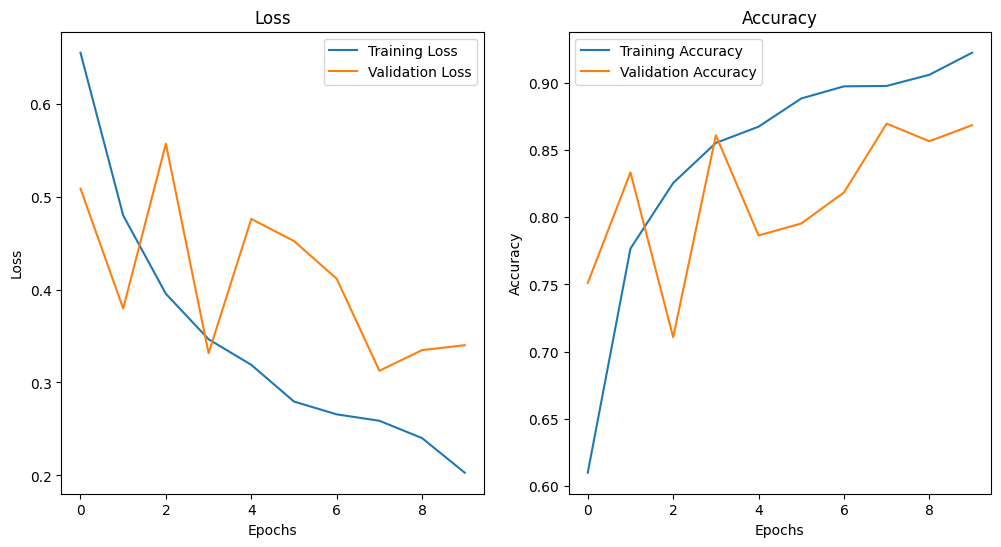

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


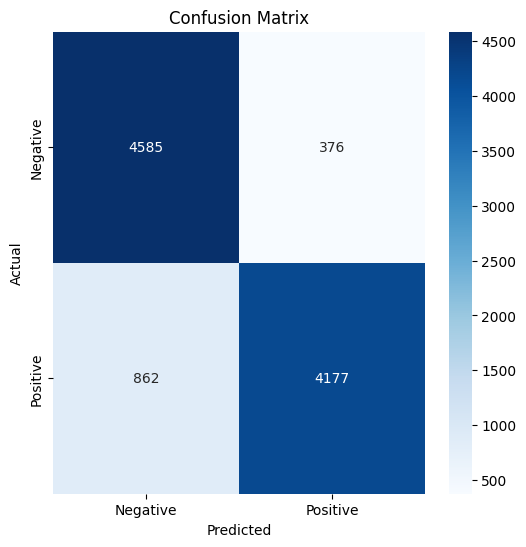

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


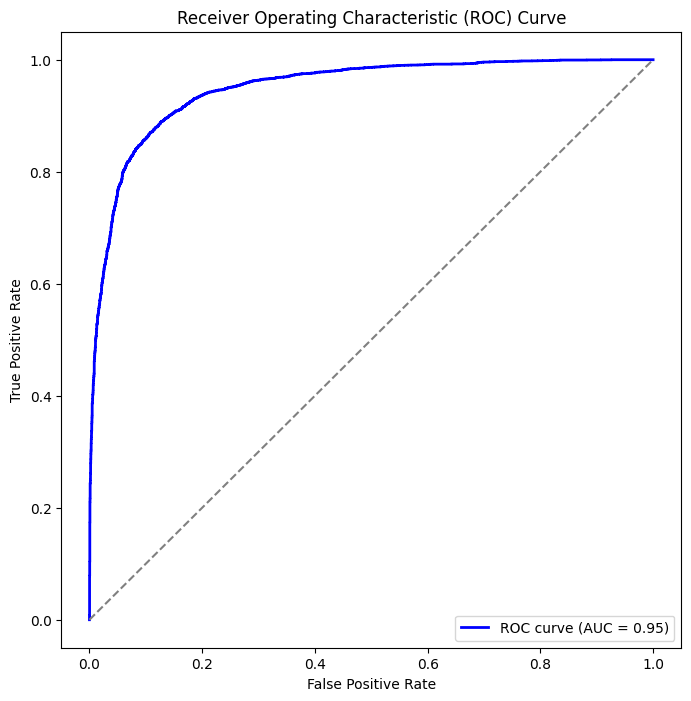

In [ ]:
plot_model(model, history, X_test, y_test)

####Bidirectional LSTM

In [ ]:
"""
Nothing different besides Bidirectional call.
"""

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, activation="tanh")))
model.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])
model.build(input_shape=(None, max_len))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 250, 64)             │       1,600,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,666,177 (6.36 MB)

 Trainable params: 1,666,177 (6.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train,y_train,epochs=10,batch_size=225,validation_split=0.4)
nn_results['Bidirectional LSTM'] = history

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5419 - loss: 0.6870 - val_accuracy: 0.7194 - val_loss: 0.5747
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7426 - loss: 0.5275 - val_accuracy: 0.7345 - val_loss: 0.5536
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8152 - loss: 0.4232 - val_accuracy: 0.8488 - val_loss: 0.3587
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8498 - loss: 0.3555 - val_accuracy: 0.8591 - val_loss: 0.3375
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8738 - loss: 0.3113 - val_accuracy: 0.8559 - val_loss: 0.3601
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8783 - loss: 0.3030 - val_accuracy: 0.8682 - val_loss: 0.3210
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8932 - loss: 0.2739 - val_accuracy: 0.8330 - val_loss: 0.4079
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9011 - loss: 0.2503 - val_accu

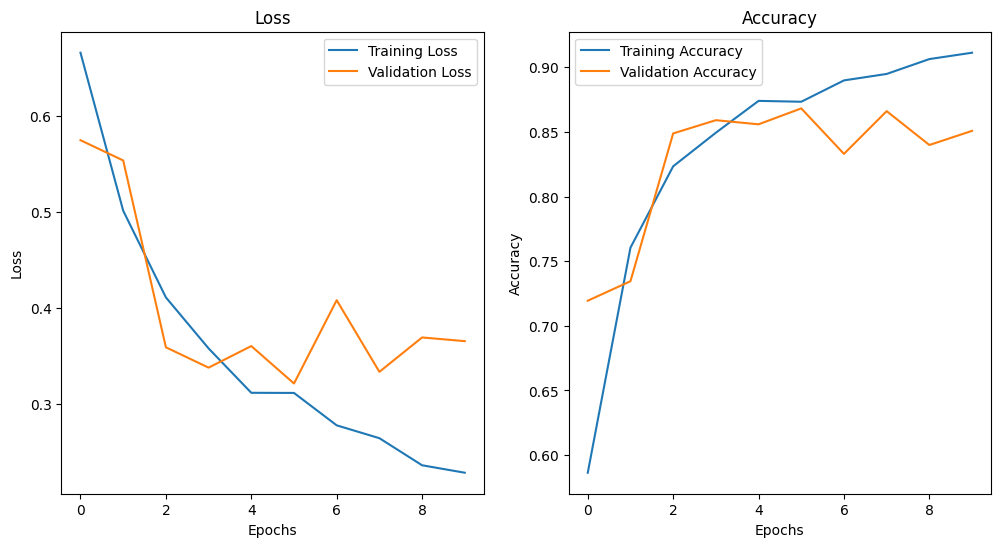

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


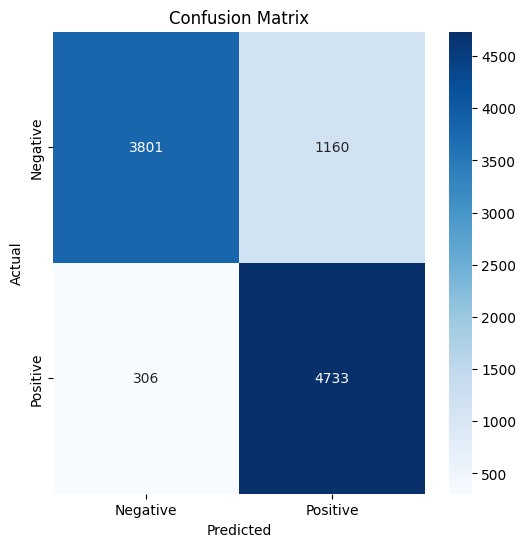

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


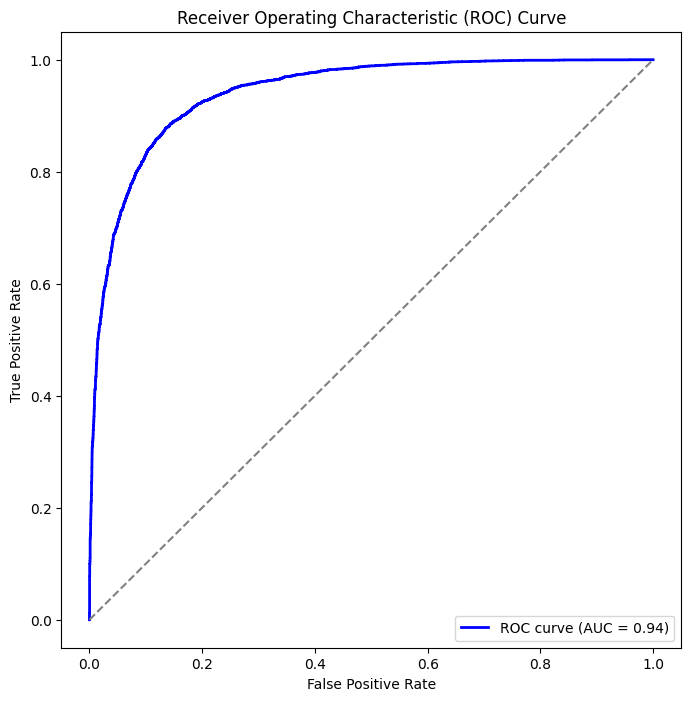

In [ ]:
plot_model(model, history, X_test, y_test)

####2b: LSTM with more **parameters**

In [ ]:
"""
Adds a second LSTM layer before the 64-unit, change embedding length to 128
About 1.6mil more params

Using a second layer versus one layer with more parameters can theoretically
help improve generalization. The return_sequences=True parameter allows that
layer to output the entire sequence of hidden states to capture temporal patterns
at every step. The second layer can then process that data to capture
high-level patterns in the data.

Stacking can capture more complex data, with the the bottom layer catching short-
term patterns and the top layer catching long-term patterns. This might be more
helpful for longer sentences/paragraphs that require more context.
"""

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=max_words,output_dim=128,input_length=max_len))
model.add(tf.keras.layers.LSTM(units=128,activation="tanh",return_sequences=True))
model.add(tf.keras.layers.LSTM(units=64,activation="tanh"))
model.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])
model.build(input_shape=(None, max_len))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 250, 128)            │       3,200,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 250, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,381,057 (12.90 MB)

 Trainable params: 3,381,057 (12.90 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train,y_train,epochs=10,batch_size=225,validation_split=0.4)
nn_results['LSTM with more parameters'] = history

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.5462 - loss: 0.6855 - val_accuracy: 0.7373 - val_loss: 0.5428
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.7341 - loss: 0.5410 - val_accuracy: 0.8008 - val_loss: 0.4504
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.8128 - loss: 0.4328 - val_accuracy: 0.8126 - val_loss: 0.4328
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.8488 - loss: 0.3640 - val_accuracy: 0.8634 - val_loss: 0.3271
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.8645 - loss: 0.3336 - val_accuracy: 0.8144 - val_loss: 0.4141
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.8814 - loss: 0.2932 - val_accuracy: 0.8730 - val_loss: 0.3147
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.8938 - loss: 0.2624 - val_accuracy: 0.8646 - val_loss: 0.3240
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9119 - loss: 0.2309 - val

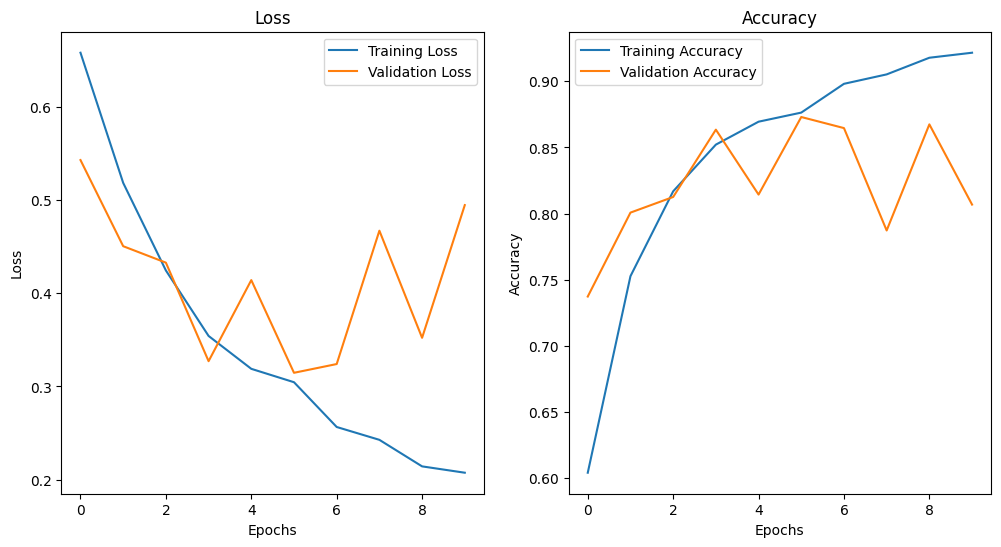

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


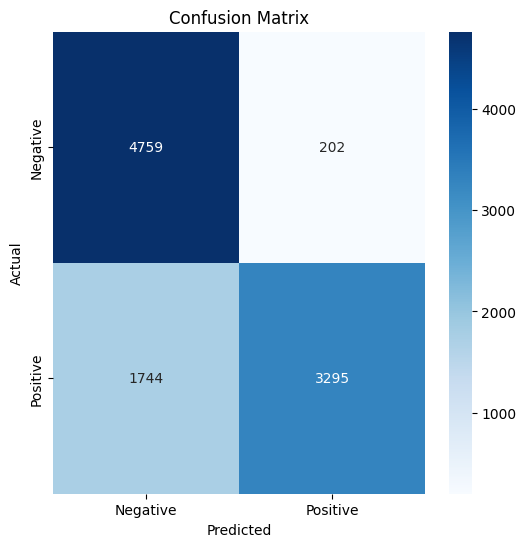

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


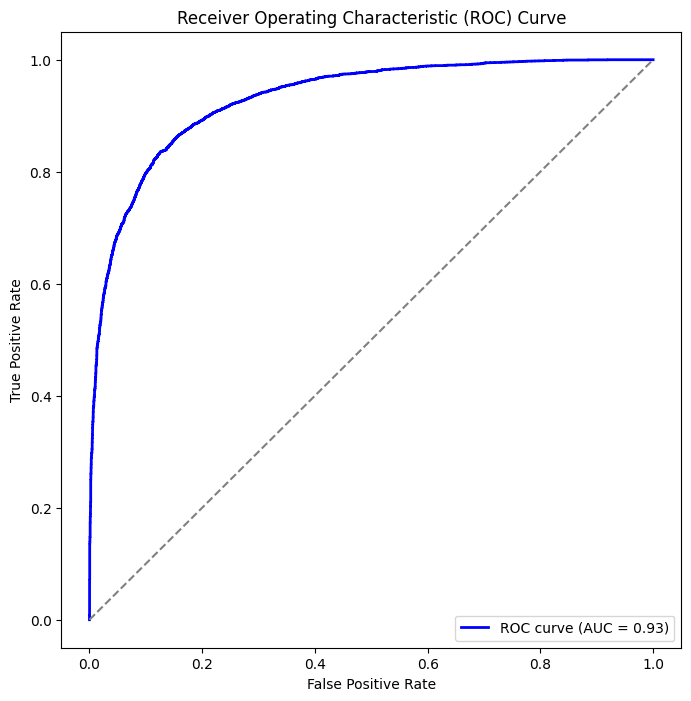

In [ ]:
plot_model(model, history, X_test, y_test)

####2c: BLSTM with more parameters

In [ ]:
"""
Bidirectional  added to both LSTM layers
"""

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=max_words,output_dim=128,input_length=max_len))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128,activation="tanh",return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64,activation="tanh")))
model.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])
model.build(input_shape=(None, max_len))
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 250, 128)            │       3,200,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 250, 256)            │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,627,649 (13.84 MB)

 Trainable params: 3,627,649 (13.84 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train,y_train,epochs=10,batch_size=225,validation_split=0.4)
nn_results['BLSTM with more parameters'] = history

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 0.5157 - loss: 0.6900 - val_accuracy: 0.6626 - val_loss: 0.6187
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.7308 - loss: 0.5505 - val_accuracy: 0.8021 - val_loss: 0.4375
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.8107 - loss: 0.4317 - val_accuracy: 0.8301 - val_loss: 0.3910
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.8493 - loss: 0.3566 - val_accuracy: 0.8291 - val_loss: 0.4032
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.8659 - loss: 0.3243 - val_accuracy: 0.8514 - val_loss: 0.3477
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.8859 - loss: 0.2852 - val_accuracy: 0.8656 - val_loss: 0.3442
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.8983 - loss: 0.2577 - val_accuracy: 0.8339 - val_loss: 0.4018
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.9201 - loss: 0

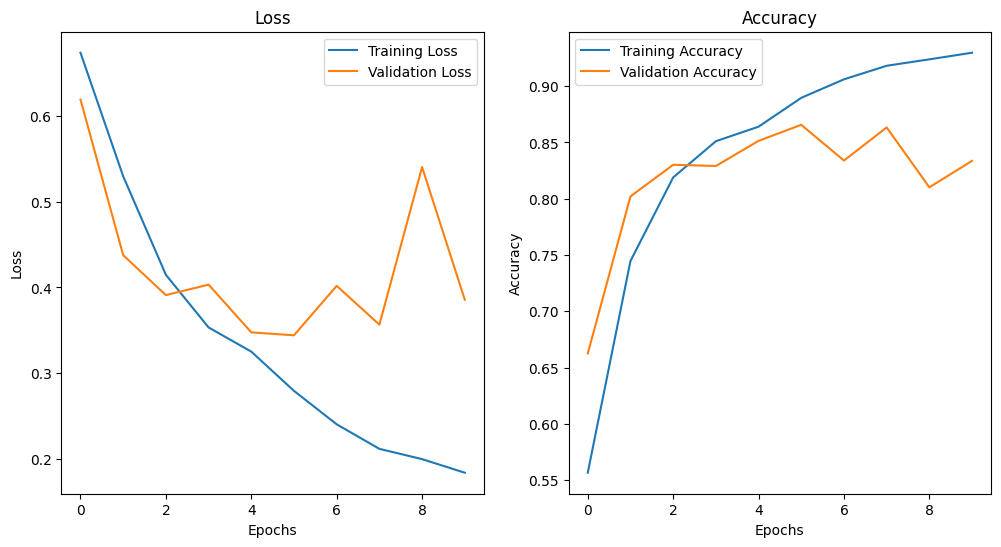

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


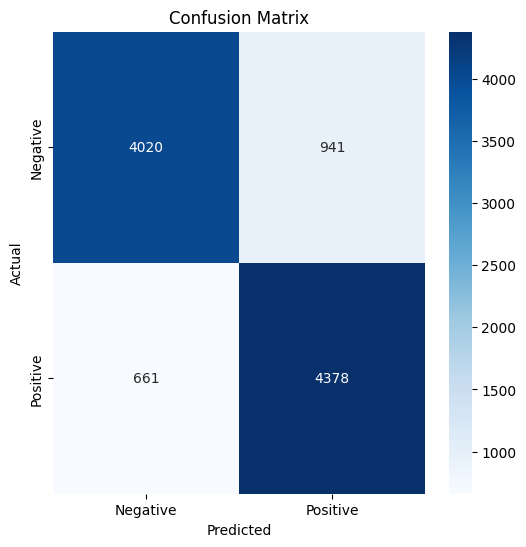

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


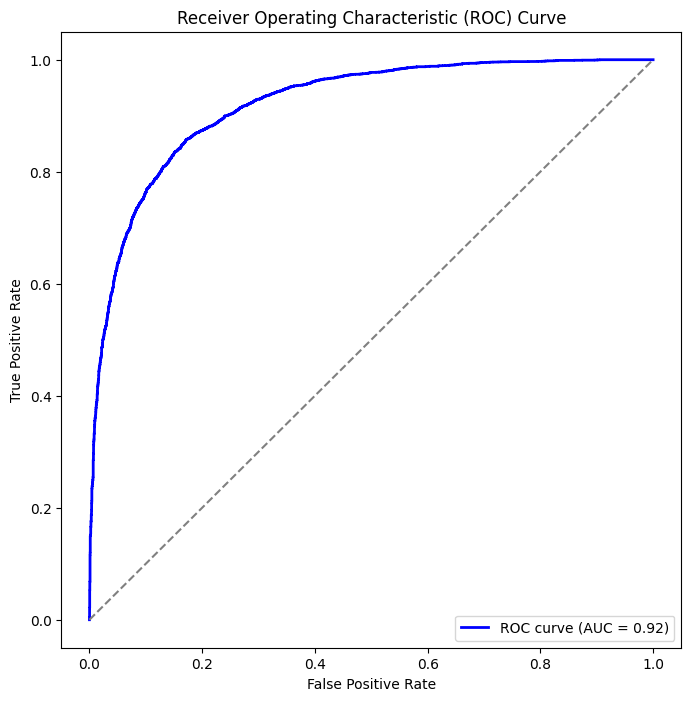

In [ ]:
plot_model(model, history, X_test, y_test)

####2d: LSTM with Overfitting prevention

In [ ]:
"""
Adds Dropout before the first LSTM layer to regularize the dense embedding,
and SpatialDropout1D after the first LSTM layer to regularize sequential features.
Includes an EarlyStopping callback to prevent overfitting by stopping training
when validation accuracy plateaus.
"""

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=max_words,output_dim=128,input_length=max_len))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=128,activation="tanh",return_sequences=True))
model.add(tf.keras.layers.SpatialDropout1D(0.2))
model.add(tf.keras.layers.LSTM(units=64,activation="tanh"))
model.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])
model.build(input_shape=(None, max_len))
model.summary()
earlyStopping =  tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_accuracy',restore_best_weights=True)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 250, 128)            │       3,200,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 250, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 250, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 250, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,381,057 (12.90 MB)

 Trainable params: 3,381,057 (12.90 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train,y_train,epochs=10,batch_size=225,validation_split=0.4,callbacks=[earlyStopping])
nn_results['LSTM with overfitting prevention'] = history

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.5453 - loss: 0.6832 - val_accuracy: 0.6945 - val_loss: 0.5914
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.7509 - loss: 0.5228 - val_accuracy: 0.7655 - val_loss: 0.4949
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.8052 - loss: 0.4298 - val_accuracy: 0.8145 - val_loss: 0.4237
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.8585 - loss: 0.3420 - val_accuracy: 0.8382 - val_loss: 0.3974
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.8783 - loss: 0.2989 - val_accuracy: 0.8662 - val_loss: 0.3222
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8763 - loss: 0.2941 - val_accuracy: 0.8664 - val_loss: 0.3286
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.8985 - loss: 0.2581 - val_accuracy: 0.8506 - val_loss: 0.3942
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.8909 - loss: 0.2741 - val_

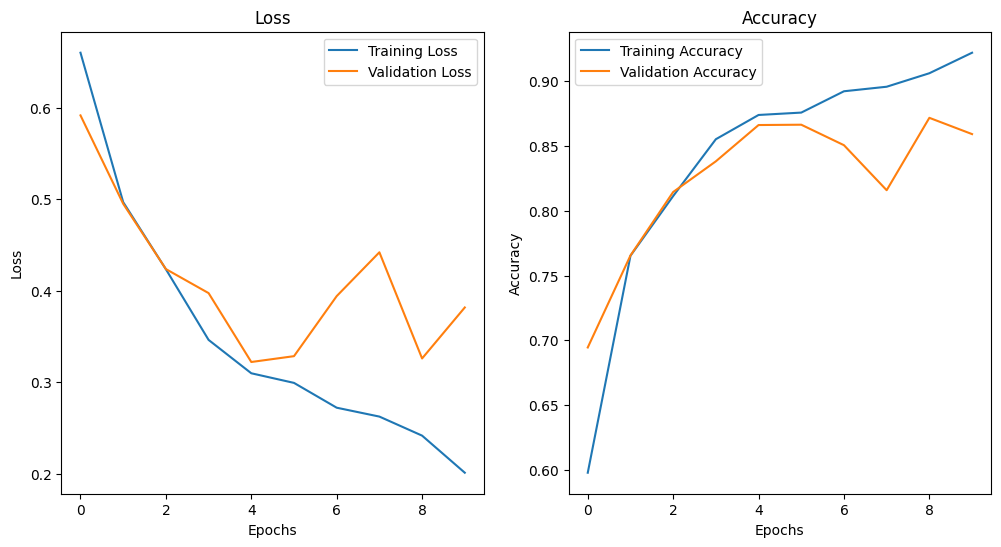

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


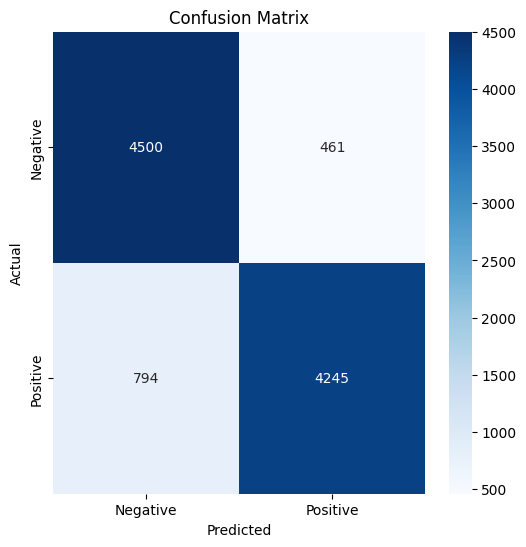

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


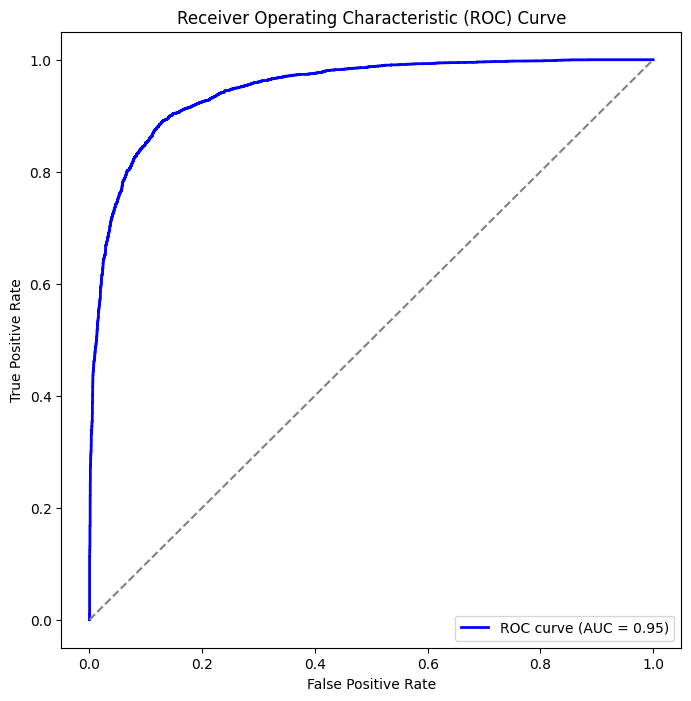

In [ ]:
plot_model(model, history, X_test, y_test)

###2e: BLSTM with overfitting prevention

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=max_words,output_dim=128,input_length=max_len))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128,activation="tanh",return_sequences=True)))
model.add(tf.keras.layers.SpatialDropout1D(0.2))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64,activation="tanh")))
model.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])
model.build(input_shape=(None, max_len))
model.summary()
earlyStopping =  tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_accuracy',restore_best_weights=True)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 250, 128)            │       3,200,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 250, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 250, 256)            │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ (None, 250, 256)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,627,649 (13.84 MB)

 Trainable params: 3,627,649 (13.84 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train,y_train,epochs=10,batch_size=225,validation_split=0.4,callbacks=[earlyStopping])
nn_results['BLSTM with overfitting prevention'] = history

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 0.5250 - loss: 0.6898 - val_accuracy: 0.7472 - val_loss: 0.5548
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.7244 - loss: 0.5592 - val_accuracy: 0.7924 - val_loss: 0.4503
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.8079 - loss: 0.4368 - val_accuracy: 0.8347 - val_loss: 0.3883
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.8497 - loss: 0.3673 - val_accuracy: 0.7607 - val_loss: 0.4823
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.8686 - loss: 0.3170 - val_accuracy: 0.8386 - val_loss: 0.3787
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.9022 - loss: 0.2490 - val_accuracy: 0.8535 - val_loss: 0.3450
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.9069 - loss: 0.2440 - val_accuracy: 0.8003 - val_loss: 0.4599
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 149ms/step - accuracy: 0.9150 - loss: 0

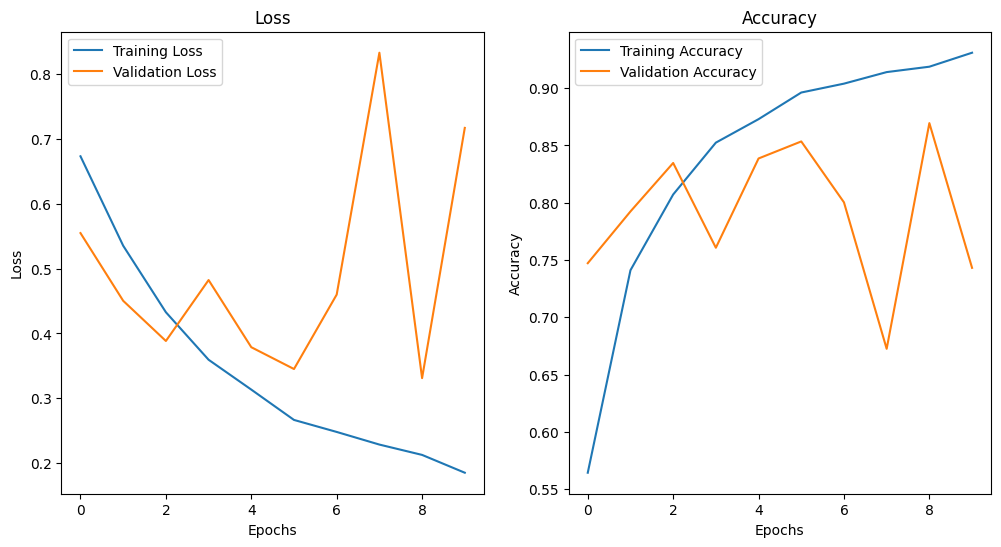

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


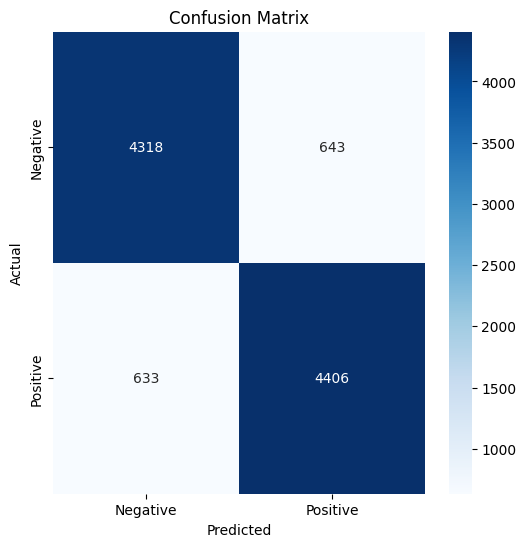

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


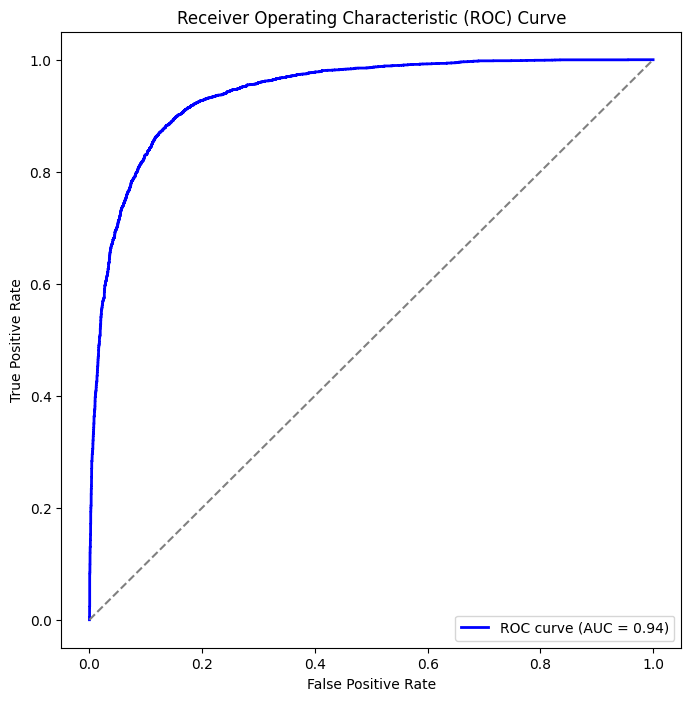

In [ ]:
plot_model(model, history, X_test, y_test)

# 3 - 1DConv

In [ ]:
onedconv_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
onedconv_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
onedconv_model.build(input_shape=(None, max_len))
onedconv_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 250, 128)            │       3,200,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 246, 128)            │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 123, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 15744)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │       1,007,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,289,793 (16.36 MB)

 Trainable params: 4,289,793 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("Training 1DConv model...")
history = onedconv_model.fit(X_train, y_train, epochs=5, batch_size=225, validation_split=0.4, validation_data=(X_test, y_test))
nn_results['1DConv'] = history
loss, onedconv_acc = onedconv_model.evaluate(X_test, y_test)

Training 1DConv model...
Epoch 1/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.6396 - loss: 0.5935 - val_accuracy: 0.8924 - val_loss: 0.2512
Epoch 2/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9301 - loss: 0.1989 - val_accuracy: 0.8936 - val_loss: 0.2618
Epoch 3/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9665 - loss: 0.1086 - val_accuracy: 0.8936 - val_loss: 0.3063
Epoch 4/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9843 - loss: 0.0533 - val_accuracy: 0.8856 - val_loss: 0.4187
Epoch 5/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9919 - loss: 0.0296 - val_accuracy: 0.8837 - val_loss: 0.4891
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8828 - loss: 0.4809


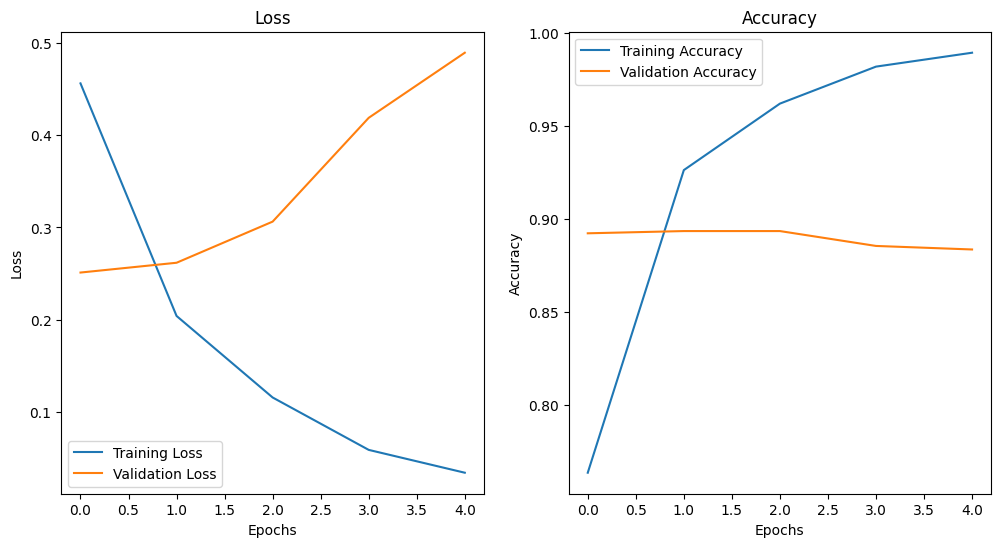

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


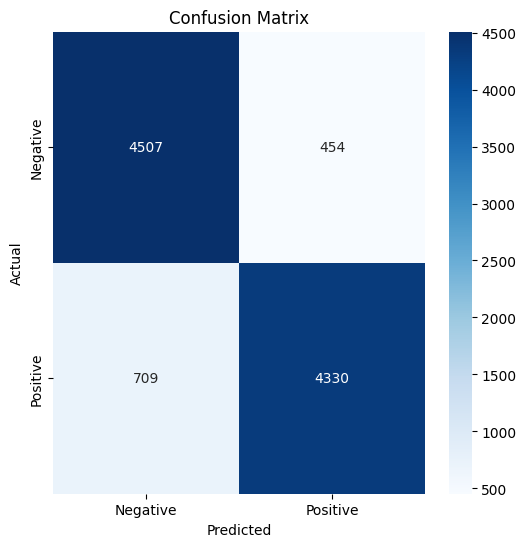

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


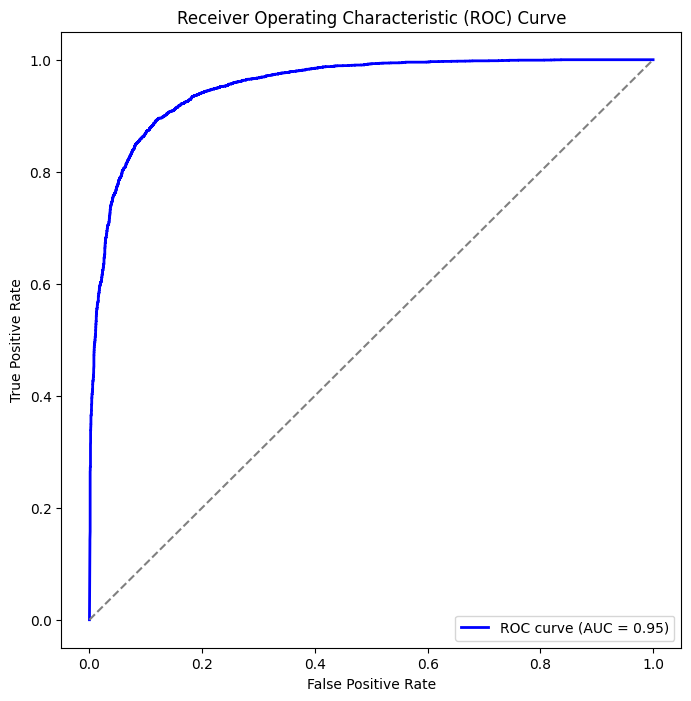

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Predict on the validation/test data
y_pred = onedconv_model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Visualize confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Get predicted probabilities for the test set
y_pred_prob = onedconv_model.predict(X_test)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# 3a - 1DConv with more parameters
1. added an extra more complicated 1DConv layer
2. increaed output_dim in the embedding layer
3. added a new more complex dense layer and accompanying dropout layer

In [ ]:
onedconv_model = Sequential([
    Embedding(input_dim=max_words, output_dim=256, input_length=max_len),
    Conv1D(filters=256, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
onedconv_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
onedconv_model.build(input_shape=(None, max_len))
onedconv_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 250, 256)            │       6,400,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 246, 256)            │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 123, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 123, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 121, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 7680)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         983,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,817,857 (29.82 MB)

 Trainable params: 7,817,857 (29.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("Training 1DConv model...")
history = onedconv_model.fit(X_train, y_train, epochs=5, batch_size=225, validation_split=0.4, validation_data=(X_test, y_test))
nn_results['1DConv with more parameters'] = history
loss, onedconv_acc = onedconv_model.evaluate(X_test, y_test)

Training 1DConv model...
Epoch 1/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step - accuracy: 0.6115 - loss: 0.6137 - val_accuracy: 0.8881 - val_loss: 0.2670
Epoch 2/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9210 - loss: 0.2162 - val_accuracy: 0.8933 - val_loss: 0.2581
Epoch 3/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9664 - loss: 0.1004 - val_accuracy: 0.8899 - val_loss: 0.3141
Epoch 4/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9855 - loss: 0.0469 - val_accuracy: 0.8873 - val_loss: 0.4747
Epoch 5/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9920 - loss: 0.0255 - val_accuracy: 0.8785 - val_loss: 0.6439
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8796 - loss: 0.6350


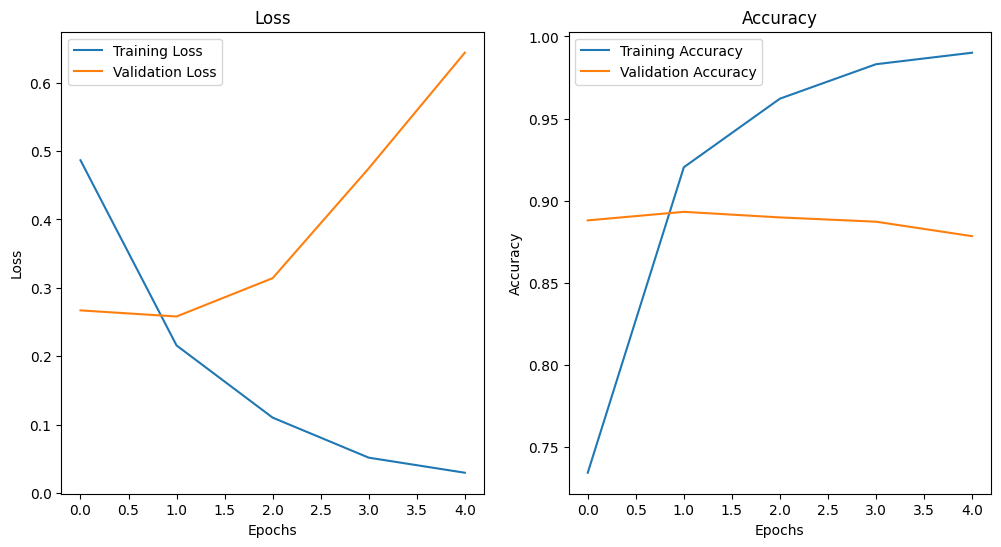

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


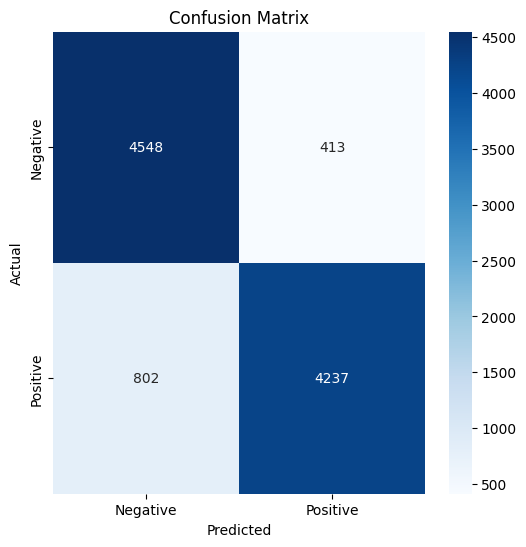

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


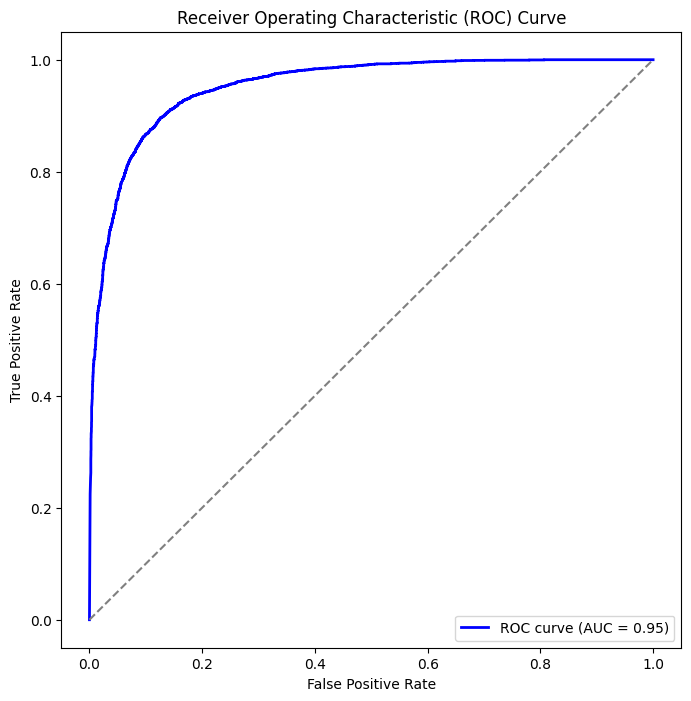

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Predict on the validation/test data
y_pred = onedconv_model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Visualize confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Get predicted probabilities for the test set
y_pred_prob = onedconv_model.predict(X_test)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# 3b - 1DConv with overfitting prevention
1. added a batch normalization after the 1DConv layer
2. added a new dropout after the MaxPooling1D
3. added L2 normalization to the 1DConv layer and the Dense layer
4. added early stopping callback to the fit function call

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

onedconv_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

onedconv_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
onedconv_model.build(input_shape=(None, max_len))
onedconv_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 250, 128)            │       3,200,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 246, 128)            │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 246, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 123, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 123, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 15744)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │       1,007,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,290,305 (16.37 MB)

 Trainable params: 4,290,049 (16.37 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
print("Training 1DConv model...")
history = onedconv_model.fit(X_train, y_train, epochs=10, batch_size=225, validation_split=0.4, validation_data=(X_test, y_test), callbacks=[early_stopping])
nn_results['1DConv with overfitting prevention'] = history
loss, onedconv_acc = onedconv_model.evaluate(X_test, y_test)

Training 1DConv model...
Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5185 - loss: 2.0161 - val_accuracy: 0.6719 - val_loss: 0.7324
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8881 - loss: 0.3869 - val_accuracy: 0.8840 - val_loss: 0.5497
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9491 - loss: 0.2246 - val_accuracy: 0.8680 - val_loss: 0.3989
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9712 - loss: 0.1598 - val_accuracy: 0.8842 - val_loss: 0.3897
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9810 - loss: 0.1338 - val_accuracy: 0.8751 - val_loss: 0.4571
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9886 - loss: 0.1016 - val_accuracy: 0.8805 - val_loss: 0.4779
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9918 - loss: 0.0869 - val_accuracy: 0.8772 - val_loss: 0.4950
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9926

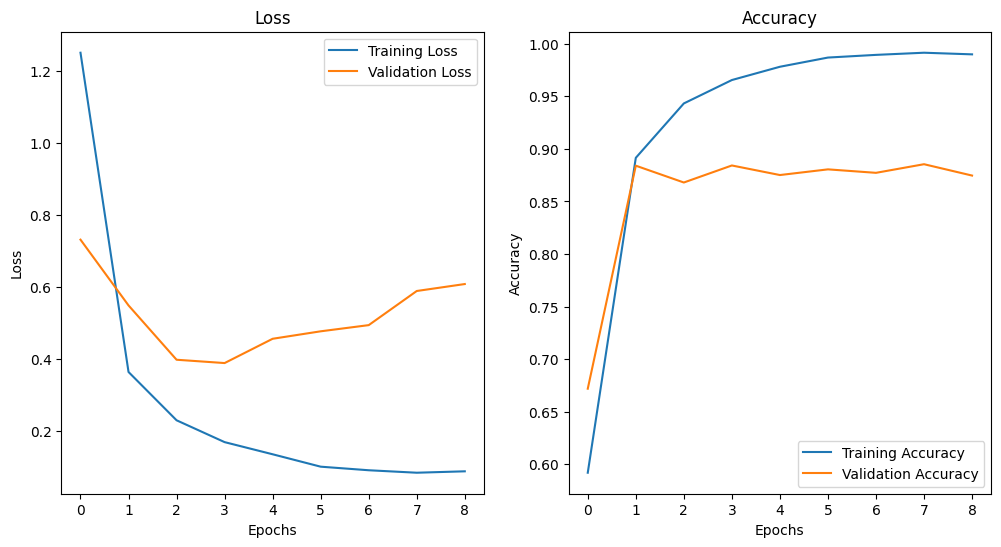

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


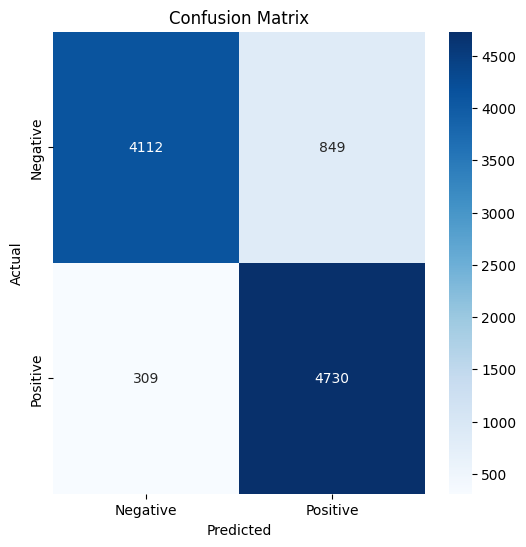

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


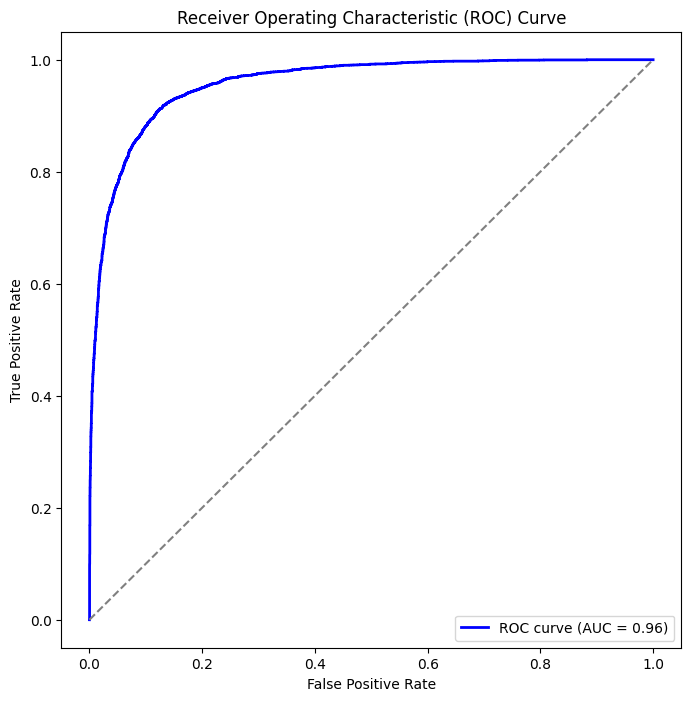

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Predict on the validation/test data
y_pred = onedconv_model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Visualize confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Get predicted probabilities for the test set
y_pred_prob = onedconv_model.predict(X_test)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_model_histories(results_dict, metric='loss'):
    plt.figure(figsize=(15, 10))
    for label, history in results_dict.items():
        if f'val_{metric}' in history:
            plt.plot(history[f'val_{metric}'], label=f'{label} (val)')
        plt.plot(history[metric], linestyle='--', label=f'{label} (train)')

    plt.title(f'Model Comparison: {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
for label in nn_results:
    if hasattr(nn_results[label], 'history'):
        nn_results[label] = nn_results[label].history

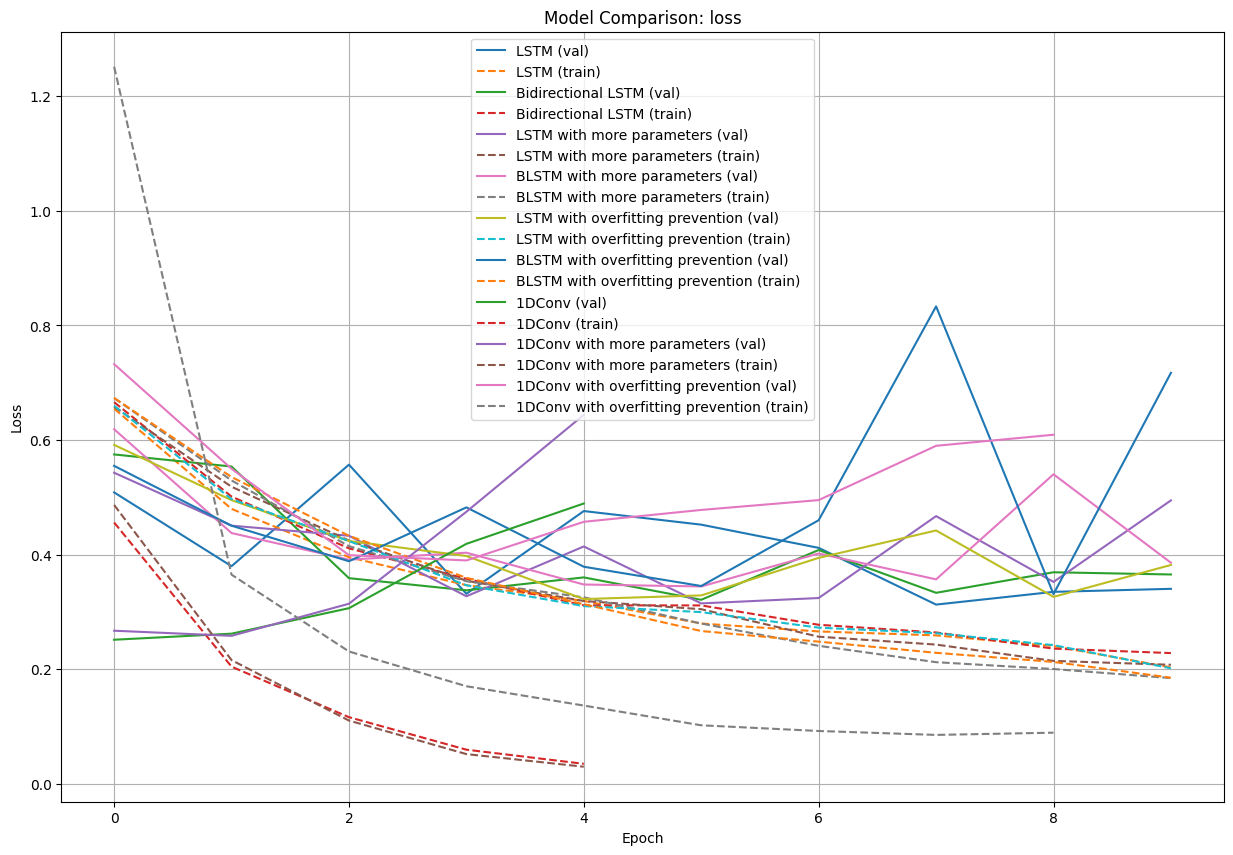

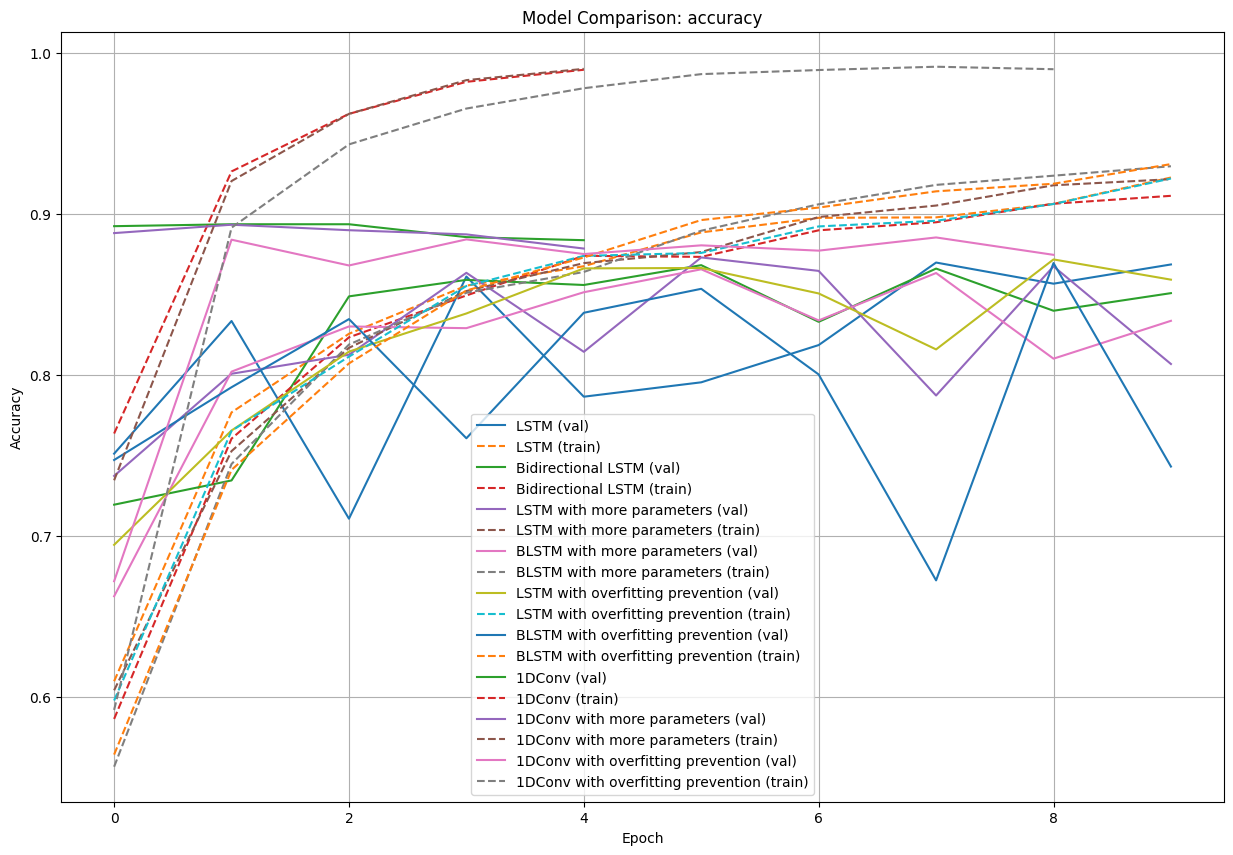

In [ ]:
plot_model_histories(nn_results, metric='loss')
plot_model_histories(nn_results, metric='accuracy')

In [ ]:
def compare_final_metrics(results_dict, metric='val_accuracy'):
    final_vals = {
        label: history[metric][-1]
        for label, history in results_dict.items()
        if metric in history
    }
    plt.figure(figsize=(8, 5))
    plt.bar(final_vals.keys(), final_vals.values())
    plt.title(f'Final {metric.replace("val_", "Validation ").capitalize()} Comparison')
    plt.ylabel(metric.split('_')[-1].capitalize())
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

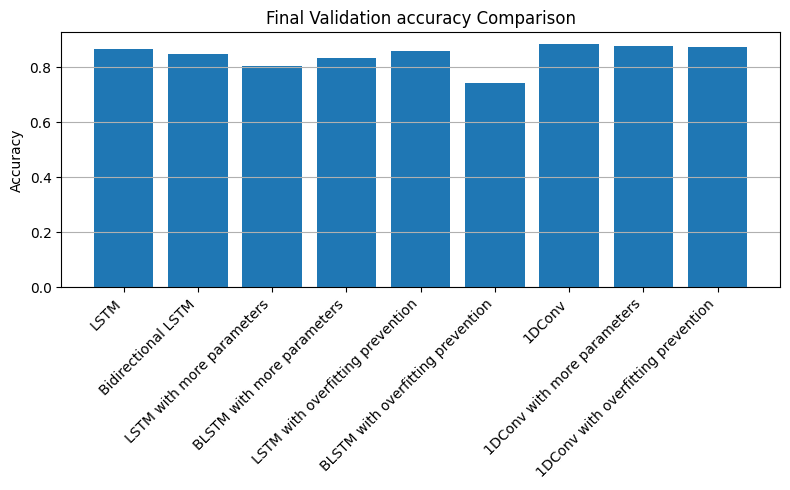

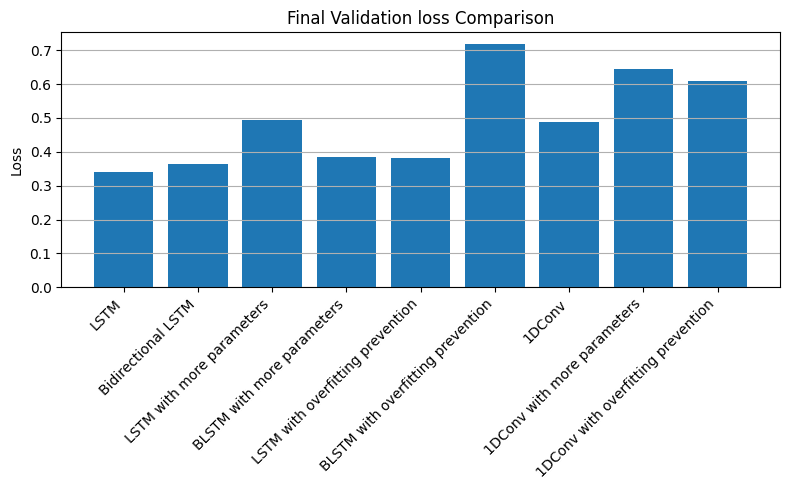

In [ ]:
compare_final_metrics(nn_results, metric='val_accuracy')
compare_final_metrics(nn_results, metric='val_loss')

In [ ]:
def plot_overfitting_gap(results_dict, metric='accuracy'):
    plt.figure(figsize=(10, 6))
    for label, history in results_dict.items():
        train = history[metric]
        val = history[f'val_{metric}']
        gap = [t - v for t, v in zip(train, val)]
        plt.plot(gap, label=label)

    plt.title(f'Overfitting Gap: {metric}')
    plt.xlabel('Epoch')
    plt.ylabel('Train - Val')
    plt.axhline(0, color='gray', linestyle='--')
    plt.legend()
    plt.grid(True)
    plt.show()

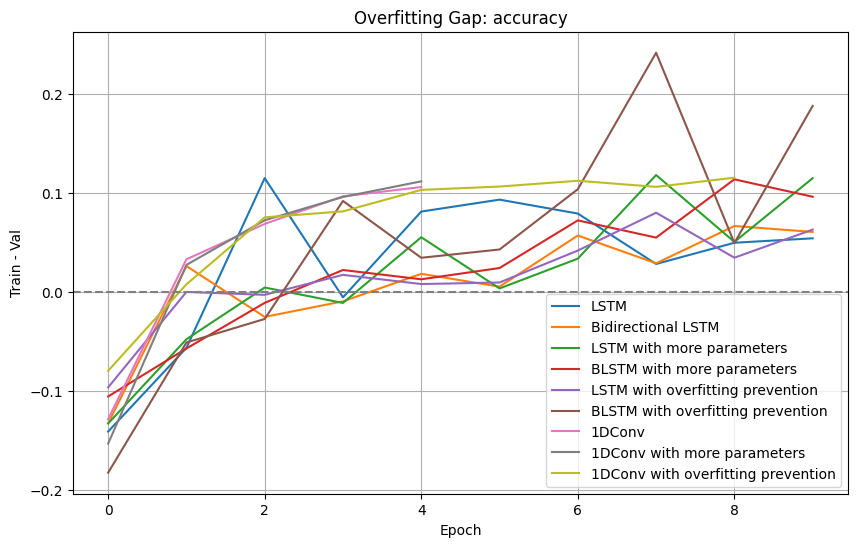

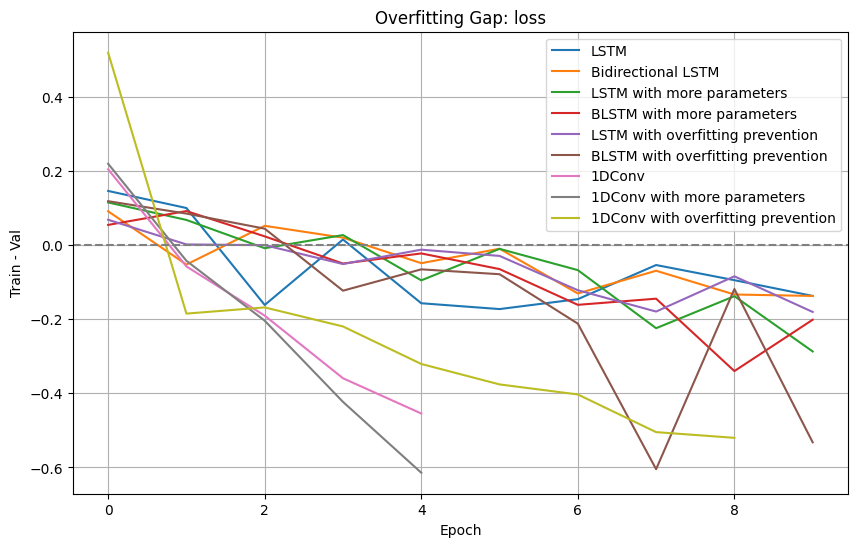

In [ ]:
plot_overfitting_gap(nn_results, metric='accuracy')
plot_overfitting_gap(nn_results, metric='loss')

In [ ]:
def plot_history_spider(nn_results):
    import matplotlib.pyplot as plt
    import numpy as np

    # Define which metrics to include (order matters)
    metrics = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
    metric_labels = ['Train Acc', 'Val Acc', 'Train Loss', 'Val Loss']

    # Get final values for each model
    model_scores = {}
    for model_name, history in nn_results.items():
        model_scores[model_name] = {metric: history[metric][-1] for metric in metrics}

    # Normalize metrics (invert loss so higher is better)
    for model in model_scores:
        model_scores[model]['loss'] = 1 - model_scores[model]['loss']
        model_scores[model]['val_loss'] = 1 - model_scores[model]['val_loss']

    # Convert to plotting format
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]

    plt.figure(figsize=(8, 8))

    for model_name, scores in model_scores.items():
        values = list(scores.values())
        values += values[:1]
        plt.polar(angles, values, label=model_name, linewidth=2)

    plt.xticks(angles[:-1], metric_labels, fontsize=12)
    plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0], color='gray', size=10)
    plt.ylim(0, 1)
    plt.title("Final Training & Validation Metrics per Model", size=15, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


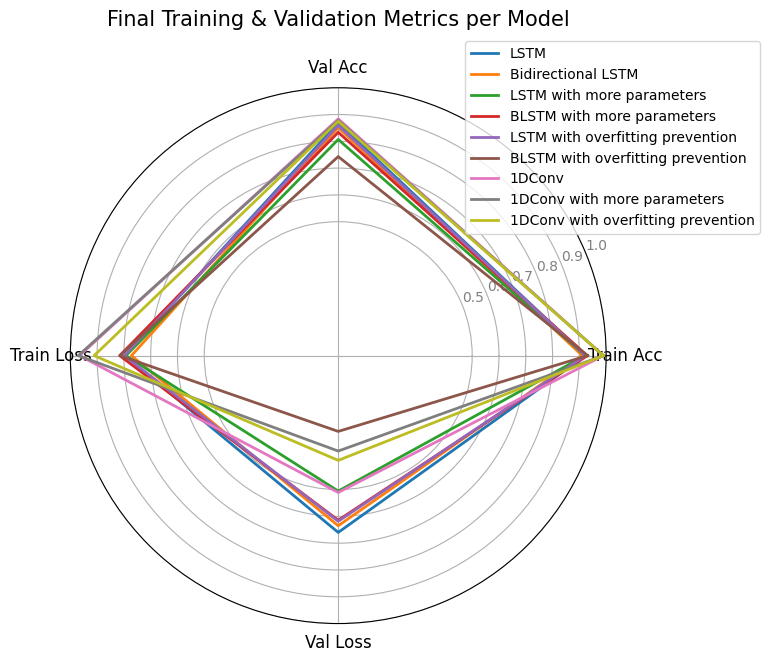

In [ ]:
plot_history_spider(nn_results)
